# Full Tutorial Building and Deploying Segmentation App with MONAI Inference Service (MIS)

This tutorial begins with creating an organ segmentation application using MONAI App SDK for a PyTorch model that has been trained with MONAI. Then this tutorial transitions into discussing how to deploy the segmentation application with the RESTful [MONAI Inference Service](https://github.com/Project-MONAI/monai-deploy-app-server/blob/main/components/inference-service/README.md).

In the following sections, we will demonstrate how to create a MONAI Deploy application package using the MONAI Deploy App SDK and then will demonstrate how to deploy this package with the [MONAI Inference Service](https://github.com/Project-MONAI/monai-deploy-app-server/blob/main/components/inference-service/README.md). Along the way we will provide verification steps to confirm that our application produces the desired output both locally (for verification) and as a service output.


## Creating Operators and connecting them in Application class

We will implement an application that consists of five Operators:

- **DICOMDataLoaderOperator**:
    - **Input(dicom_files)**: a folder path ([`DataPath`](/modules/_autosummary/monai.deploy.core.domain.DataPath))
    - **Output(dicom_study_list)**: a list of DICOM studies in memory (List[[`DICOMStudy`](/modules/_autosummary/monai.deploy.core.domain.DICOMStudy)])
- **DICOMSeriesSelectorOperator**:
    - **Input(dicom_study_list)**: a list of DICOM studies in memory (List[[`DICOMStudy`](/modules/_autosummary/monai.deploy.core.domain.DICOMStudy)])
    - **Input(selection_rules)**: a selection rule (Dict)
    - **Output(study_selected_series_list)**: a DICOM series object in memory ([`StudySelectedSeries`](/modules/_autosummary/monai.deploy.core.domain.StudySelectedSeries))
- **DICOMSeriesToVolumeOperator**:
    - **Input(study_selected_series_list)**: a DICOM series object in memory ([`StudySelectedSeries`](/modules/_autosummary/monai.deploy.core.domain.StudySelectedSeries))
    - **Output(image)**: an image object in memory ([`Image`](/modules/_autosummary/monai.deploy.core.domain.Image))
- **SpleenSegOperator**:
    - **Input(image)**: an image object in memory ([`Image`](/modules/_autosummary/monai.deploy.core.domain.Image))
    - **Output(seg_image)**: an image object in memory ([`Image`](/modules/_autosummary/monai.deploy.core.domain.Image))
- **DICOMSegmentationWriterOperator**:
    - **Input(seg_image)**: a segmentation image object in memory ([`Image`](/modules/_autosummary/monai.deploy.core.domain.Image))
    - **Input(study_selected_series_list)**: a DICOM series object in memory ([`StudySelectedSeries`](/modules/_autosummary/monai.deploy.core.domain.StudySelectedSeries))
    - **Output(dicom_seg_instance)**: a file path ([`DataPath`](/modules/_autosummary/monai.deploy.core.domain.DataPath))


:::{note}
The `DICOMSegmentationWriterOperator` needs both the segmentation image as well as the original DICOM series meta-data in order to use the patient demographics and the DICOM Study level attributes.
:::

The workflow of the application would look like this.

```{mermaid}
%%{init: {"theme": "base", "themeVariables": { "fontSize": "16px"}} }%%

classDiagram
    direction TB

    DICOMDataLoaderOperator --|> DICOMSeriesSelectorOperator : dicom_study_list...dicom_study_list
    DICOMSeriesSelectorOperator --|> DICOMSeriesToVolumeOperator : study_selected_series_list...study_selected_series_list
    DICOMSeriesToVolumeOperator --|> SpleenSegOperator : image...image
    DICOMSeriesSelectorOperator --|> DICOMSegmentationWriterOperator : study_selected_series_list...study_selected_series_list
    SpleenSegOperator --|> DICOMSegmentationWriterOperator : seg_image...seg_image


    class DICOMDataLoaderOperator {
        <in>dicom_files : DISK
        dicom_study_list(out) IN_MEMORY
    }
    class DICOMSeriesSelectorOperator {
        <in>dicom_study_list : IN_MEMORY
        <in>selection_rules : IN_MEMORY
        study_selected_series_list(out) IN_MEMORY
    }
    class DICOMSeriesToVolumeOperator {
        <in>study_selected_series_list : IN_MEMORY
        image(out) IN_MEMORY
    }
    class SpleenSegOperator {
        <in>image : IN_MEMORY
        seg_image(out) IN_MEMORY
    }
    class DICOMSegmentationWriterOperator {
        <in>seg_image : IN_MEMORY
        <in>study_selected_series_list : IN_MEMORY
        dicom_seg_instance(out) DISK
    }
```

### Setup environment


In [1]:
# Install MONAI and other necessary image processing packages for the application
!python -c "import monai" || pip install -q "monai"
!python -c "import torch" || pip install -q "torch>=1.5"
!python -c "import numpy" || pip install -q "numpy>=1.20"
!python -c "import nibabel" || pip install -q "nibabel>=3.2.1"
!python -c "import pydicom" || pip install -q "pydicom>=1.4.2"
!python -c "import SimpleITK" || pip install -q "SimpleITK>=2.0.0"
!python -c "import typeguard" || pip install -q "typeguard>=2.12.1"
!python -c "import nilearn" || pip install -q "nilearn>=0.8.1"

# Install MONAI Deploy App SDK package
!python -c "import monai.deploy" || pip install --upgrade -q "monai-deploy-app-sdk"

### Download/Extract ai_spleen_seg_data from Google Drive

In [2]:
# Download ai_spleen_seg_data.zip
!pip install gdown 
!gdown https://drive.google.com/uc?id=1uTQsm8omwimBcp_kRXlduWBP2M6cspr1

# After downloading ai_spleen_seg_data.zip from the web browser or using gdown,
!unzip -o "ai_spleen_seg_data.zip"

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Downloading...
From: https://drive.google.com/uc?id=1uTQsm8omwimBcp_kRXlduWBP2M6cspr1
To: /home/gbae/repo/monai-deploy-app-sdk/notebooks/tutorials/ai_spleen_seg_data.zip
104MB [00:10, 10.3MB/s] 
Archive:  ai_spleen_seg_data.zip
   creating: dcm/
  inflating: dcm/IMG0001.dcm         
  inflating: dcm/IMG0002.dcm         
  inflating: dcm/IMG0003.dcm         
  inflating: dcm/IMG0004.dcm         
  inflating: dcm/IMG0005.dcm         
  inflating: dcm/IMG0006.dcm         
  inflating: dcm/IMG0007.dcm         
  inflating: dcm/IMG0008.dcm         
  inflating: dcm/IMG0009.dcm         
  inflating: dcm/IMG0010.dcm         
  inflating: dcm/IMG0011.dcm         
  inflating: dcm/IMG0012.dcm         
  inflating: dcm/IMG0013.dcm         
  inflating: dcm/IMG0014.dcm         
  inflating: dcm/IMG0015.dcm         
  inflating: dcm/IMG0016.dcm         
  inflating: dcm/IMG0017.dcm         
  inflating: dcm/IMG0018.dcm       

### Setup imports

Let's import necessary classes/decorators to define Application and Operator.

In [3]:
import logging
from os import path

from numpy import uint8

import monai.deploy.core as md
from monai.deploy.core import ExecutionContext, Image, InputContext, IOType, Operator, OutputContext
from monai.deploy.operators.monai_seg_inference_operator import InMemImageReader, MonaiSegInferenceOperator
from monai.transforms import (
    Activationsd,
    AsDiscreted,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    Invertd,
    LoadImaged,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)

from monai.deploy.core import Application, resource
from monai.deploy.operators.dicom_data_loader_operator import DICOMDataLoaderOperator
from monai.deploy.operators.dicom_seg_writer_operator import DICOMSegmentationWriterOperator
from monai.deploy.operators.dicom_series_selector_operator import DICOMSeriesSelectorOperator
from monai.deploy.operators.dicom_series_to_volume_operator import DICOMSeriesToVolumeOperator

### Creating Model Specific Inference Operator classes

Each Operator class inherits [Operator](/modules/_autosummary/monai.deploy.core.Operator) class and input/output properties are specified by using [@input](/modules/_autosummary/monai.deploy.core.input)/[@output](/modules/_autosummary/monai.deploy.core.output) decorators.

Business logic would be implemented in the <a href="../../modules/_autosummary/monai.deploy.core.Operator.html#monai.deploy.core.Operator.compute">compute()</a> method.

The App SDK provides a `MonaiSegInferenceOperator` class to perform segmentation prediction with a Torch Script model. For consistency, this class uses MONAI dictionary-based transforms, as `Compose` object, for pre and post transforms. The model-specific inference operator will then only need to create the pre and post transform `Compose` based on what has been used in the model training and validation. Note that for deploy application, `ignite` is not needed nor supported.

#### SpleenSegOperator

The `SpleenSegOperator` gets as input an in-memory [Image](/modules/_autosummary/monai.deploy.core.domain.Image) object that has been converted from a DICOM CT series by the preceding `DICOMSeriesToVolumeOperator`, and as output in-memory segmentation [Image](/modules/_autosummary/monai.deploy.core.domain.Image) object.

The `pre_process` function creates the pre-transforms `Compose` object. For `LoadImage`, a specialized `InMemImageReader`, derived from MONAI `ImageReader`, is used to convert the in-memory pixel data and return the `numpy` array as well as the meta-data. Also, the DICOM input pixel spacings are often not the same as expected by the model, so the `Spacingd` transform must be used to re-sample the image with the expected spacing.

The `post_process` function creates the post-transform `Compose` object. The `SaveImageD` transform class is used to save the segmentation mask as NIfTI image file, which is optional as the in-memory mask image will be passed down to the DICOM Segmentation writer for creating a DICOM Segmentation instance. The `Invertd` must also be used to revert the segmentation image's orientation and spacing to be the same as the input.

When the `MonaiSegInferenceOperator` object is created, the `ROI` size is specified, as well as the transform `Compose` objects. Furthermore, the dataset image key names are set accordingly.

Loading of the model and performing the prediction are encapsulated in the `MonaiSegInferenceOperator` and other SDK classes. Once the inference is completed, the segmentation [Image](/modules/_autosummary/monai.deploy.core.domain.Image) object is created and set to the output (<a href="../../modules/_autosummary/monai.deploy.core.OutputContext.html#monai.deploy.core.OutputContext.set">op_output.set(value, label)</a>), by the `MonaiSegInferenceOperator`.

In [4]:
@md.input("image", Image, IOType.IN_MEMORY)
@md.output("seg_image", Image, IOType.IN_MEMORY)
@md.env(pip_packages=["monai==0.6.0", "torch>=1.5", "numpy>=1.20", "nibabel"])
class SpleenSegOperator(Operator):
    """Performs Spleen segmentation with a 3D image converted from a DICOM CT series.
    """

    def __init__(self):

        self.logger = logging.getLogger("{}.{}".format(__name__, type(self).__name__))
        super().__init__()
        self._input_dataset_key = "image"
        self._pred_dataset_key = "pred"

    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):

        input_image = op_input.get("image")
        if not input_image:
            raise ValueError("Input image is not found.")

        output_path = context.output.get().path

        # This operator gets an in-memory Image object, so a specialized ImageReader is needed.
        _reader = InMemImageReader(input_image)
        pre_transforms = self.pre_process(_reader)
        post_transforms = self.post_process(pre_transforms, path.join(output_path, "prediction_output"))

        # Delegates inference and saving output to the built-in operator.
        infer_operator = MonaiSegInferenceOperator(
            (
                160,
                160,
                160,
            ),
            pre_transforms,
            post_transforms,
        )

        # Setting the keys used in the dictironary based transforms may change.
        infer_operator.input_dataset_key = self._input_dataset_key
        infer_operator.pred_dataset_key = self._pred_dataset_key

        # Now let the built-in operator handles the work with the I/O spec and execution context.
        infer_operator.compute(op_input, op_output, context)

    def pre_process(self, img_reader) -> Compose:
        """Composes transforms for preprocessing input before predicting on a model."""

        my_key = self._input_dataset_key
        return Compose(
            [
                LoadImaged(keys=my_key, reader=img_reader),
                EnsureChannelFirstd(keys=my_key),
                Spacingd(keys=my_key, pixdim=[1.0, 1.0, 1.0], mode=["blinear"], align_corners=True),
                ScaleIntensityRanged(keys=my_key, a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
                CropForegroundd(keys=my_key, source_key=my_key),
                ToTensord(keys=my_key),
            ]
        )

    def post_process(self, pre_transforms: Compose, out_dir: str = "./prediction_output") -> Compose:
        """Composes transforms for postprocessing the prediction results."""

        pred_key = self._pred_dataset_key
        return Compose(
            [
                Activationsd(keys=pred_key, softmax=True),
                AsDiscreted(keys=pred_key, argmax=True),
                Invertd(
                    keys=pred_key, transform=pre_transforms, orig_keys=self._input_dataset_key, nearest_interp=True
                ),
                SaveImaged(keys=pred_key, output_dir=out_dir, output_postfix="seg", output_dtype=uint8, resample=False),
            ]
        )


### Creating Application class

Our application class would look like below.

It defines `App` class, inheriting [Application](/modules/_autosummary/monai.deploy.core.Application) class.

The requirements (resource and package dependency) for the App can be specified by using [@resource](/modules/_autosummary/monai.deploy.core.resource) and [@env](/modules/_autosummary/monai.deploy.core.env) decorators.

The base class method, `compose`, is overridden. Objects required for DICOM parsing, series selection (selecting the first series for the current release), pixel data conversion to volume image, and segmentation instance creation are created, so is the model-specific `SpleenSegOperator`. The execution pipeline, as a Directed Acyclic Graph, is created by connecting these objects through <a href="../../modules/_autosummary/monai.deploy.core.Application.html#monai.deploy.core.Application.add_flow">self.add_flow()</a>.

In [5]:
@resource(cpu=1, gpu=1, memory="7Gi")
class AISpleenSegApp(Application):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def compose(self):

        study_loader_op = DICOMDataLoaderOperator()
        series_selector_op = DICOMSeriesSelectorOperator()
        series_to_vol_op = DICOMSeriesToVolumeOperator()
        # Creates DICOM Seg writer with segment label name in a string list
        dicom_seg_writer = DICOMSegmentationWriterOperator(seg_labels=["Spleen"])

        # Creates the model specific segmentation operator
        spleen_seg_op = SpleenSegOperator()

        # Creates the DAG by linking the operators
        self.add_flow(study_loader_op, series_selector_op, {"dicom_study_list": "dicom_study_list"})
        self.add_flow(series_selector_op, series_to_vol_op, {"study_selected_series_list": "study_selected_series_list"})
        self.add_flow(series_to_vol_op, spleen_seg_op, {"image": "image"})

        self.add_flow(series_selector_op, dicom_seg_writer, {"study_selected_series_list": "study_selected_series_list"})
        self.add_flow(spleen_seg_op, dicom_seg_writer, {"seg_image": "seg_image"})


## Executing app locally

We can execute the app in the Jupyter notebook. Note that the DICOM files of the CT Abdomen series must be present in the `dcm` and the Torch Script model at `model.pt`. Please use the actual path in your environment.


In [6]:
app = AISpleenSegApp()

app.run(input="dcm", output="output", model="model.pt")

Going to initiate execution of operator DICOMDataLoaderOperator
Executing operator DICOMDataLoaderOperator (Process ID: 3885, Operator ID: a345e29f-33ba-44d6-ac64-f4c37edf3eed)
Done performing execution of operator DICOMDataLoaderOperator

Going to initiate execution of operator DICOMSeriesSelectorOperator
Executing operator DICOMSeriesSelectorOperator (Process ID: 3885, Operator ID: ad5e3c12-6c1c-42c1-b5ae-f02124e2b4d8)
Done performing execution of operator DICOMSeriesSelectorOperator

Going to initiate execution of operator DICOMSeriesToVolumeOperator
Executing operator DICOMSeriesToVolumeOperator (Process ID: 3885, Operator ID: 1702a7dd-5cc7-4acc-bbab-d6c5e191471b)
Done performing execution of operator DICOMSeriesToVolumeOperator

Going to initiate execution of operator SpleenSegOperator
Executing operator SpleenSegOperator (Process ID: 3885, Operator ID: 6222eee5-4a70-424e-b010-2263d41c8ccf)


[2021-09-23 02:20:17,805] [INFO] (monai.deploy.operators.dicom_seg_writer_operator.DICOMSegWriter) - Number of DICOM instance datasets in the list: 515
[2021-09-23 02:20:17,806] [INFO] (monai.deploy.operators.dicom_seg_writer_operator.DICOMSegWriter) - Number of slices in the numpy image: 515
[2021-09-23 02:20:17,807] [INFO] (monai.deploy.operators.dicom_seg_writer_operator.DICOMSegWriter) - Labels of the segments: ['Spleen']


file written: /home/gbae/repo/monai-deploy-app-sdk/notebooks/tutorials/output/prediction_output/Img_in_context/Img_in_context_seg.nii.gz.
Output Seg image numpy array shaped: (515, 440, 440)
Output Seg image pixel max value: 1
Done performing execution of operator SpleenSegOperator

Going to initiate execution of operator DICOMSegmentationWriterOperator
Executing operator DICOMSegmentationWriterOperator (Process ID: 3885, Operator ID: d6208465-9e0e-44fa-8b71-938c490b7c04)


[2021-09-23 02:20:19,972] [INFO] (monai.deploy.operators.dicom_seg_writer_operator.DICOMSegWriter) - Unique values in seg image: [0 1]
[2021-09-23 02:20:21,118] [INFO] (monai.deploy.operators.dicom_seg_writer_operator.DICOMSegWriter) - Saving output file /home/gbae/repo/monai-deploy-app-sdk/notebooks/tutorials/output/dicom_seg-DICOMSEG.dcm
[2021-09-23 02:20:21,397] [INFO] (monai.deploy.operators.dicom_seg_writer_operator.DICOMSegWriter) - File saved.


Done performing execution of operator DICOMSegmentationWriterOperator



Once the application is verified inside Jupyter notebook, we can write the above Python code into Python files in an application folder.

The application folder structure would look like below:

```bash
my_app
├── __main__.py
├── app.py
└── spleen_seg_operator.py
```

:::{note}
We can create a single application Python file (such as `spleen_app.py`) that includes the content of the files, instead of creating multiple files.
You will see such an example in <a href="./02_mednist_app.html#executing-app-locally">MedNist Classifier Tutorial</a>.
:::

In [7]:
# Create an application folder
!mkdir -p my_app

### spleen_seg_operator.py

In [8]:
%%writefile my_app/spleen_seg_operator.py
import logging
from os import path

from numpy import uint8

import monai.deploy.core as md
from monai.deploy.core import ExecutionContext, Image, InputContext, IOType, Operator, OutputContext
from monai.deploy.operators.monai_seg_inference_operator import InMemImageReader, MonaiSegInferenceOperator
from monai.transforms import (
    Activationsd,
    AsDiscreted,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    Invertd,
    LoadImaged,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)


@md.input("image", Image, IOType.IN_MEMORY)
@md.output("seg_image", Image, IOType.IN_MEMORY)
@md.env(pip_packages=["monai==0.6.0", "torch>=1.5", "numpy>=1.20", "nibabel", "typeguard"])
class SpleenSegOperator(Operator):
    """Performs Spleen segmentation with a 3D image converted from a DICOM CT series.
    """

    def __init__(self):

        self.logger = logging.getLogger("{}.{}".format(__name__, type(self).__name__))
        super().__init__()
        self._input_dataset_key = "image"
        self._pred_dataset_key = "pred"

    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):

        input_image = op_input.get("image")
        if not input_image:
            raise ValueError("Input image is not found.")

        output_path = context.output.get().path

        # This operator gets an in-memory Image object, so a specialized ImageReader is needed.
        _reader = InMemImageReader(input_image)
        pre_transforms = self.pre_process(_reader)
        post_transforms = self.post_process(pre_transforms, path.join(output_path, "prediction_output"))

        # Delegates inference and saving output to the built-in operator.
        infer_operator = MonaiSegInferenceOperator(
            (
                160,
                160,
                160,
            ),
            pre_transforms,
            post_transforms,
        )

        # Setting the keys used in the dictironary based transforms may change.
        infer_operator.input_dataset_key = self._input_dataset_key
        infer_operator.pred_dataset_key = self._pred_dataset_key

        # Now let the built-in operator handles the work with the I/O spec and execution context.
        infer_operator.compute(op_input, op_output, context)

    def pre_process(self, img_reader) -> Compose:
        """Composes transforms for preprocessing input before predicting on a model."""

        my_key = self._input_dataset_key
        return Compose(
            [
                LoadImaged(keys=my_key, reader=img_reader),
                EnsureChannelFirstd(keys=my_key),
                Spacingd(keys=my_key, pixdim=[1.0, 1.0, 1.0], mode=["blinear"], align_corners=True),
                ScaleIntensityRanged(keys=my_key, a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
                CropForegroundd(keys=my_key, source_key=my_key),
                ToTensord(keys=my_key),
            ]
        )

    def post_process(self, pre_transforms: Compose, out_dir: str = "./prediction_output") -> Compose:
        """Composes transforms for postprocessing the prediction results."""

        pred_key = self._pred_dataset_key
        return Compose(
            [
                Activationsd(keys=pred_key, softmax=True),
                AsDiscreted(keys=pred_key, argmax=True),
                Invertd(
                    keys=pred_key, transform=pre_transforms, orig_keys=self._input_dataset_key, nearest_interp=True
                ),
                SaveImaged(keys=pred_key, output_dir=out_dir, output_postfix="seg", output_dtype=uint8, resample=False),
            ]
        )


Writing my_app/spleen_seg_operator.py


### app.py

In [9]:
%%writefile my_app/app.py
import logging

from spleen_seg_operator import SpleenSegOperator

from monai.deploy.core import Application, resource
from monai.deploy.operators.dicom_data_loader_operator import DICOMDataLoaderOperator
from monai.deploy.operators.dicom_seg_writer_operator import DICOMSegmentationWriterOperator
from monai.deploy.operators.dicom_series_selector_operator import DICOMSeriesSelectorOperator
from monai.deploy.operators.dicom_series_to_volume_operator import DICOMSeriesToVolumeOperator

@resource(cpu=1, gpu=1, memory="7Gi")
class AISpleenSegApp(Application):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def compose(self):

        study_loader_op = DICOMDataLoaderOperator()
        series_selector_op = DICOMSeriesSelectorOperator(Sample_Rules_Text)
        series_to_vol_op = DICOMSeriesToVolumeOperator()
        # Creates DICOM Seg writer with segment label name in a string list
        dicom_seg_writer = DICOMSegmentationWriterOperator(seg_labels=["Spleen"])
        # Creates the model specific segmentation operator
        spleen_seg_op = SpleenSegOperator()

        # Creates the DAG by link the operators
        self.add_flow(study_loader_op, series_selector_op, {"dicom_study_list": "dicom_study_list"})
        self.add_flow(series_selector_op, series_to_vol_op, {"study_selected_series_list": "study_selected_series_list"})
        self.add_flow(series_to_vol_op, spleen_seg_op, {"image": "image"})
        self.add_flow(series_selector_op, dicom_seg_writer, {"study_selected_series_list": "study_selected_series_list"})
        self.add_flow(spleen_seg_op, dicom_seg_writer, {"seg_image": "seg_image"})

# This is a sample series selection rule in JSON, simply selecting CT series.
# If the study has more than 1 CT series, then all of them will be selected.
# Please see more detail in DICOMSeriesSelectorOperator.
Sample_Rules_Text = """
{
    "selections": [
        {
            "name": "CT Series",
            "conditions": {
                "StudyDescription": "(.*?)",
                "Modality": "(?i)CT",
                "SeriesDescription": "(.*?)"
            }
        }
    ]
}
"""

if __name__ == "__main__":
    # Creates the app and test it standalone. When running is this mode, please note the following:
    #     -i <DICOM folder>, for input DICOM CT series folder
    #     -o <output folder>, for the output folder, default $PWD/output
    #     -m <model file>, for model file path
    # e.g.
    #     python3 app.py -i input -m model.pt
    #
    AISpleenSegApp(do_run=True)

Writing my_app/app.py


```python
if __name__ == "__main__":
    AISpleenSegApp(do_run=True)
```

The above lines are needed to execute the application code by using `python` interpreter.

### \_\_main\_\_.py

\_\_main\_\_.py is needed for <a href="../../developing_with_sdk/packaging_app.html#required-arguments">MONAI Application Packager</a> to detect the main application code (`app.py`) when the application is executed with the application folder path (e.g., `python simple_imaging_app`).

In [10]:
%%writefile my_app/__main__.py
from app import AISpleenSegApp

if __name__ == "__main__":
    AISpleenSegApp(do_run=True)

Writing my_app/__main__.py


In [11]:
!ls my_app

__main__.py  app.py  spleen_seg_operator.py


In this time, let's execute the app in the command line.

In [12]:
!python my_app -i dcm -o output -m model.pt

Going to initiate execution of operator DICOMDataLoaderOperator
Executing operator DICOMDataLoaderOperator (Process ID: 5326, Operator ID: ba037402-5d1d-4133-944b-080397ff5ac5)
Done performing execution of operator DICOMDataLoaderOperator

Going to initiate execution of operator DICOMSeriesSelectorOperator
Executing operator DICOMSeriesSelectorOperator (Process ID: 5326, Operator ID: 9fe72901-dd8b-4574-8378-7a13fb927d92)
Done performing execution of operator DICOMSeriesSelectorOperator

Going to initiate execution of operator DICOMSeriesToVolumeOperator
Executing operator DICOMSeriesToVolumeOperator (Process ID: 5326, Operator ID: ea353df5-0177-4286-bd63-0e2456d9f4f0)
Done performing execution of operator DICOMSeriesToVolumeOperator

Going to initiate execution of operator SpleenSegOperator
Executing operator SpleenSegOperator (Process ID: 5326, Operator ID: a46c7abc-1f90-4009-80d2-0804b23221db)
file written: /home/gbae/repo/monai-deploy-app-sdk/notebooks/tutorials/output/prediction_ou

Above command is same with the following command line:

In [13]:
!monai-deploy exec my_app -i dcm -o output -m model.pt

Going to initiate execution of operator DICOMDataLoaderOperator
Executing operator DICOMDataLoaderOperator (Process ID: 5905, Operator ID: 24d2620a-fdc0-46ce-b87b-f24311e63532)
Done performing execution of operator DICOMDataLoaderOperator

Going to initiate execution of operator DICOMSeriesSelectorOperator
Executing operator DICOMSeriesSelectorOperator (Process ID: 5905, Operator ID: 5e6f5d1c-6812-4b07-8090-ea05cec57f04)
Done performing execution of operator DICOMSeriesSelectorOperator

Going to initiate execution of operator DICOMSeriesToVolumeOperator
Executing operator DICOMSeriesToVolumeOperator (Process ID: 5905, Operator ID: 7b51ddcd-ad2c-4cca-ad95-2b9b39cfea8d)
Done performing execution of operator DICOMSeriesToVolumeOperator

Going to initiate execution of operator SpleenSegOperator
Executing operator SpleenSegOperator (Process ID: 5905, Operator ID: 33da2642-2729-46ea-afe0-632e2a1ae5fc)
file written: /home/gbae/repo/monai-deploy-app-sdk/notebooks/tutorials/output/prediction_ou

In [14]:
!ls output

dicom_seg-DICOMSEG.dcm	prediction_output


## Packaging app

Let's package the app with [MONAI Application Packager](/developing_with_sdk/packaging_app).

In [15]:
!monai-deploy package my_app --tag my_app:latest -m model.pt

Building MONAI Application Package... Done
[2021-09-23 02:20:50,882] [INFO] (app_packager) - Successfully built my_app:latest


:::{note}
Building a MONAI Application Package (Docker image) can take time. Use `-l DEBUG` option if you want to see the progress.
:::

We can see that the Docker image is created.

In [16]:
!docker image ls | grep my_app

my_app                                                                  latest                                   7176a8fc6df7        6 minutes ago        15.6GB


## Executing packaged app locally

The packaged app can be run locally through [MONAI Application Runner](/developing_with_sdk/executing_packaged_app_locally).

In [17]:
# Copy DICOM files are in 'dcm' folder

# Launch the app
!monai-deploy run my_app:latest dcm output

Checking dependencies...
--> Verifying if "docker" is installed...

--> Verifying if "my_app:latest" is available...

Checking for MAP "my_app:latest" locally
"my_app:latest" found.

Reading MONAI App Package manifest...
 > export '/var/run/monai/export/' detected
--> Verifying if "nvidia-docker" is installed...

Going to initiate execution of operator DICOMDataLoaderOperator
Executing operator DICOMDataLoaderOperator (Process ID: 1, Operator ID: 8ae35b26-50b3-45e1-8e31-f6ceeabd067e)
Done performing execution of operator DICOMDataLoaderOperator

Going to initiate execution of operator DICOMSeriesSelectorOperator
Executing operator DICOMSeriesSelectorOperator (Process ID: 1, Operator ID: 1145bd17-87e6-4ef2-aea4-193bf5b7de2b)
Done performing execution of operator DICOMSeriesSelectorOperator

Going to initiate execution of operator DICOMSeriesToVolumeOperator
Executing operator DICOMSeriesToVolumeOperator (Process ID: 1, Operator ID: 514e95ba-fc8b-4134-be5a-9f2f9fd77955)
Done performing e

In [18]:
!ls output

dicom_seg-DICOMSEG.dcm	prediction_output


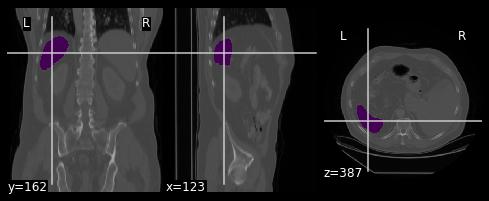

In [10]:
def visualize_output(predicted_output: str):
    import SimpleITK as sitk
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames('./dcm')
    reader.SetFileNames(dicom_names)
    input_image = reader.Execute()

    writer = sitk.ImageFileWriter()
    writer.SetFileName('input.nii.gz')
    writer.Execute(input_image)

    import nibabel as nib
    input_image_nib = nib.load('input.nii.gz')

    image_itk = nib.load(predicted_output)

    from nilearn import plotting, image
    display = plotting.plot_anat(input_image_nib, cut_coords=(123, 162, 387), colorbar=False)
    display.add_overlay(image_itk)

visualize_output("output/prediction_output/1.2.826.0.1.3680043.2.1125.1/1.2.826.0.1.3680043.2.1125.1_seg.nii.gz")

## Exporting Application and Package Manifest Files

Given a succesfully built MAP image, its manifest files can be extracted with all configured paramters. This can be done by running `docker run` with the image and making sure to map a local volume (ex. ./output) to `"/var/run/monai/export/config/"` within the contianer

In [5]:
!mkdir ./export
!docker run -it -v "$(pwd)/export/":"/var/run/monai/export/config/" my_app:latest

= > export '/var/run/monai/export/' detected


After running, two `.json` files (application and package manifests) can be found inside
of the local directory volume mount

In [82]:
!ls ./export/

app.json  pkg.json


In [83]:
!cat ./export/app.json

{
    "api-version": "0.1.0",
    "command": "python3 -u /opt/monai/app/app.py",
    "environment": {},
    "input": {
        "formats": [],
        "path": "input"
    },
    "output": {
        "format": {},
        "path": "output"
    },
    "sdk-version": "0.1.1",
    "timeout": 0,
    "version": "0.0.0",
    "working-directory": "/var/monai/"
}

In [84]:
!cat ./export/pkg.json

{
    "api-version": "0.1.0",
    "application-root": "/var/monai/",
    "models": [
        {
            "name": "model-54dd6cdaac290a0e800c0fa627cd60410bb2cea173ac8bb2f4816cc54ea88c90",
            "path": "/opt/monai/models/model/model.pt"
        }
    ],
    "resources": {
        "cpu": 1,
        "gpu": 1,
        "memory": "7168Mi"
    },
    "sdk-version": "0.1.1",
    "version": "0.0.0"
}

## Deploying MONAI Inference Service (MIS)

With the MONAI application package image we built, we can now deploy it with the
[MONAI Inference Service](https://github.com/Project-MONAI/monai-deploy-app-server/blob/main/components/inference-service/README.md).

This is a RESTful service which will allow other users to make inference requests
with our MAP using HTTP.

We first need to clone the MIS repository and build the MIS container.

In [14]:
!git clone https://github.com/Project-MONAI/monai-deploy-app-server.git
%cd monai-deploy-app-server/components/inference-service
!./build.sh
%cd -

Cloning into 'monai-deploy-app-server'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (274/274), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 274 (delta 127), reused 213 (delta 90), pack-reused 0
Receiving objects: 100% (274/274), 79.20 KiB | 705.00 KiB/s, done.
Resolving deltas: 100% (127/127), done.
/home/kavink/src/work_folder/monai-deploy-app-sdk/notebooks/tutorials/monai-deploy-app-server/components/inference-service

Step 1/12 : FROM python:3.9-slim-buster
 ---> edd87973afe0
Step 2/12 : LABEL "base"="python:3.9-slim-buster"
 ---> Using cache
 ---> 74208e399b3d
Step 3/12 : ARG APTVER_CURL=7.64.0-4+deb10u2
 ---> Using cache
 ---> 86f5d84752a5
Step 4/12 : ARG APTVER_TRANSPORT_HTTPS=1.8.2.2
 ---> Using cache
 ---> 094aa1423e82
Step 5/12 : ARG APTVER_GNUPG2=2.2.12-1+deb10u1
 ---> Using cache
 ---> a6e28500ca8a
Step 6/12 : RUN apt-get update     && apt-get install -y --no-install-recommends     apt-transport-https=${APTVER_TRANSPORT_

Now, we need to acquire the MIS helm charts and provide them with information of our MAP

In [31]:
!gdown https://drive.google.com/uc?id=12uNO1tyqZh1oFkZH41Osliey7TRm-BBG
!unzip -o charts.zip

Downloading...
From: https://drive.google.com/uc?id=12uNO1tyqZh1oFkZH41Osliey7TRm-BBG
To: /home/kavink/src/work_folder/monai-deploy-app-sdk/notebooks/tutorials/charts.zip
100%|██████████████████████████████████████| 9.18k/9.18k [00:00<00:00, 10.9MB/s]
Archive:  charts.zip
  inflating: charts/templates/monaiinferenceservice-deployment.yaml  
  inflating: charts/templates/monaiinferenceservice-service.yaml  
  inflating: charts/templates/monaiinferenceservice-clusterrole.yaml  
  inflating: charts/templates/monaiinferenceservice-payload-volume.yaml  
  inflating: charts/templates/monaiinferenceservice-serviceaccount.yaml  
  inflating: charts/templates/monaiinferenceservice-clusterrolebinding.yaml  
  inflating: charts/templates/monaiinferenceservice-payload-volume-claim.yaml  
  inflating: charts/templates/_helpers.tpl  
  inflating: charts/Chart.yaml       
  inflating: charts/values.yaml      


Before starting MONAI Inference Service, a set of values must be specified within
`./charts/values.yaml` to configure the MIS instance with a MAP:

| Parameter      | Value Description |
| ----------- | ----------- |
| `images.monaiInferenceServiceTag` | MONAI Inference Service image name (`pritishnahar/monai-deploy`) |
| `images.monaiInferenceService` | MONAI Inference Service image tag (`inference-service-0.1`) |
| `payloadService.hostVolumePath` | Path to a local directory which will serve as a shared volume for payloads between MIS and its pods |
| `map.urn` | Name:Tag of MAP image built with MONAI application packager |
| `map.entrypoint` | Application entrypoint which can obtained from `app.json` |
| `map.cpu` | Number of CPUs requested by application which can be obtained either from `pkg.json` OR from when we created app.py (check @resource decorator) |
| `map.memory` | Memory requested by application which can be obtained either from `pkg.json` OR from when we created app.py (check @resource decorator) |
| `map.gpu` | Number of GPUs requested by application which can be obtained either from `pkg.json` OR from when we created app.py (check @resource decorator) |
| `map.inputPath` | Input volume path within MAP container, can be derived by appending the `input.path` with the `working-directory` in `app.json` |
| `map.outputPath` | Output volume path within MAP container, can be derived by appending the `output.path` with the `working-directory` in `app.json` |
| `map.modelPath` | Model volume path within MAP container, can be derived using a `path` of an entry under `models` in `pkg.json`, and taking the sub-path where the `/model` folder resides (ex: `path: "/opt/monai/models/model/model.pt"` ->  `"/opt/monai/models"`) |

In [19]:
%%writefile charts/values.yaml
# Default values for MONAI Inference Service.
# This is a YAML-formatted file.
# Declare variables to be passed into your templates.
images:
  monaiInferenceService: monai/inference-service
  monaiInferenceServiceTag: 0.1

########################################################
#   Configuration Values for MONAI Inference Service   #
########################################################

server:
  names:
    clusterRole: monai-inference-service-cluster-role
    clusterRoleBinding: monai-inference-service-binding
    deployment: monai-inference-service
    service: monai-inference-service
    serviceAccount: monai-inference-service-service-account
    storageClass: monai-inference-service-storage-class
    volume: monai-inference-service-payload-volume
    volumeClaim: monai-inference-service-payload-volume-claim

  serviceType: NodePort # Alternatively: ClusterIp if only in cluster clients will exist
  nodePort: 32000
  pullSecrets: []
  targetPort: 8000

  # Configuration for the payload service in the MONAI Inference Service.
  payloadService:
    # The path on the node running MONAI Inference Service where a payload will be stored.
    # The input directory and output directory that are created by MONAI Inference Service
    # will exist as a directory inside this path. 
    # (e.g. "/monai/payload/input").
    # Please make sure that this directory has read, write, and execute permissions for the user,
    # group, and all other users `rwxrwxrwx`. Running `chmod 777 <hostVolumePath>` will achomplish this.
    hostVolumePath: "/monai/payload"

  # MAP configuration.
  map:
    # MAP Container <image>:<tag> to de deployed by MONAI Inference Service.
    # For example, urn: "ubuntu:latest"
    urn: "my_app:latest"

    # String value which defines entry point command for MAP Container.
    # For example, entrypoint: "/bin/echo Hello"
    entrypoint: "python3 -u /opt/monai/app/app.py"

    # Integer value which defines the CPU limit assigned to the MAP container.
    # This value can not be less than 1.
    cpu: 1

    # Integer value in Megabytes which defines the Memory limit assigned to the MAP container.
    # This value can not be less than 256.
    memory: 7168

    # Integer value which defines the number of GPUs assigned to the MAP container.
    # This value can not be less than 0.
    gpu: 1

    # Input directory path of MAP Container.
    # An environment variable `MONAI_INPUTPATH` is mounted in the MAP container
    # with it's value equal to the one provided for this field.
    inputPath: "/var/monai/input"

    # Output directory path of MAP Container.
    # An environment variable `MONAI_OUTPUTPATH` is mounted in the MAP container
    # with it's value equal to the one provided for this field.
    outputPath: "/var/monai/output"

    # Model directory path of MAP Container.
    # For example, modelPath: /opt/monai/models.
    # An environment variable `MONAI_MODELPATH` is mounted in the MAP container
    # with it's value equal to the one provided for this field.
    modelPath: "/opt/monai/models"

Overwriting charts/values.yaml


Now we are ready to deploy our MIS instance:

In [27]:
!helm install monai ./charts/

NAME: monai
LAST DEPLOYED: Thu Nov 18 16:17:05 2021
NAMESPACE: default
STATUS: deployed
REVISION: 1
TEST SUITE: None


In [30]:
!kubectl get po

NAME                                       READY   STATUS    RESTARTS   AGE
monai-inference-service-7fcc7f5b69-qmp9s   1/1     Running   0          76s


### Inferencing Segmentation AI with MIS

With our MIS instance running as a kubernetes pod, we can now submit REST inferencing 
requests to it

We first need to compress our dicom files under `/dcm` into a compressed .zip as
MIS accepts that format

In [22]:
!cd dcm; zip -rq ../input.zip *
!ls input.zip

input.zip


Now that we have our compressed .zip, we can now making an inferencing request to our
MIS instance using `curl`

**Usage:**
```bash
curl -X 'POST' 'http://[CLUSTER-IP:8000 OR HOST-IP:32000]/upload/' \
    -H 'accept: application/json' \
    -H 'Content-Type: multipart/form-data' \
    -F 'file=@[PATH TO INPUT PAYLOAD ZIP];type=application/x-zip-compressed' \
    -o output.zip
```

You can obtain the cluster IP of the MIS Kubernetes service by doing a `kubectl get svc`.

For example,
```bash
user@hostname:~$ kubectl get svc
NAME                      TYPE        CLUSTER-IP     EXTERNAL-IP   PORT(S)          AGE
kubernetes                ClusterIP   10.96.0.1      <none>        443/TCP          8d
monai-inference-service   NodePort    10.97.138.32   <none>        8000:32000/TCP   4s
```
Under the entry `monai-inference-service`, note the IP registered under the `CLUSTER-IP` section. This is the Cluster IP of the MIS.

In [29]:
!curl -X 'POST' 'http://10.108.206.27:8000/upload/' \
    -H 'accept: application/json' \
    -H 'Content-Type: multipart/form-data' \
    -F 'file=@input.zip;type=application/x-zip-compressed' \
    -o output.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86.6M  100 87283  100 86.5M   3185  3233k  0:00:27  0:00:27 --:--:-- 18523


In [24]:
!unzip -o output.zip

Archive:  output.zip
  inflating: output/dicom_seg-DICOMSEG.dcm  
  inflating: output/prediction_output/1.2.826.0.1.3680043.2.1125.1/1.2.826.0.1.3680043.2.1125.1_seg.nii.gz  


/home/kavink/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


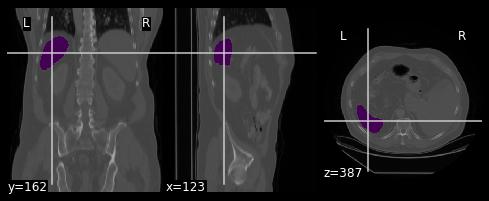

In [8]:
visualize_output("output/prediction_output/1.2.826.0.1.3680043.2.1125.1/1.2.826.0.1.3680043.2.1125.1_seg.nii.gz")

**Uninstalling MONAI Inference Service**

In [25]:
!helm uninstall monai

release "monai" uninstalled
